In [1]:
import os
os.chdir(os.path.expanduser("~/ppi-core-genes/"))
from speos.utils.datahandlers import ResultsHandler
from speos.postprocessing.postprocessor import PostProcessor
from speos.utils.config import Config
from speos.visualization.settings import *

import numpy as np
import matplotlib as plt

# Gather the data and adjust pvals jointly

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

phenotypes = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "TAG", "GCN", "N2V+MLP", "MLP"]
groups = ["Noncandidate Gene", "Candidate Gene", "Mendelian"]
categories = ["DT", "#DC", "Dr", "Dr-"]
tick_size = 12
label_size = 14

from statsmodels.stats.multitest import fdrcorrection as fdr
crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
grey = "#bbbbbb"
lightgrey = "#dddddd"
width_ratios= [10, 1]*2
marker_size=10

colors_ = [crimson, jungle, tan, navy, petrol]

results_dict_values = {}
results_dict_pvals = {}
outer_dfs =  []
for phenotype in phenotypes:
    plot_df_values = pd.DataFrame(columns=categories, index=["Mendelians"] + pretty_methods)
    plot_df_pvals = pd.DataFrame(columns=categories, index=["Mendelians"] + pretty_methods)
    need_to_set_mendelians = True
    dfs = []
    for method, pretty_method in zip(methods, pretty_methods):

        if method in ["gcn", "mlp", "n2vmlp"] and phenotype == "Immune Dysregulation":
            method += "_new"
    
        config_paths = {"Insulin Disorders": "configs/config_insulin_disorder_{}.yaml".format(method),
                        "Diabetes": "configs/config_diabetes_{}.yaml".format(method),
                        "Body Mass Disorders": "configs/config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "configs/config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "configs/config_immune_dysregulation_{}.yaml".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            config_paths[phenotype] = "configs/config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json

        outer_results_paths = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

                        

        if method == "film" and phenotype == "Immune Dysregulation":
            outer_results_paths[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forrealouter_results.json".format(method)

        results_files = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}_outer_0_fold_1.tsv".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}_outer_0_fold_1.tsv".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_outer_0_fold_1.tsv".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            results_files[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forreal_outer_0_fold_1.tsv".format(method)

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)
        pp.outer_result = results
        pp.init_pp_table()
        drug_target_results, pvals, (not_predicted_degrees, predicted_degrees, positive_degrees), df = pp.drugtarget(results_files[phenotype], plot=False)
        
        total_druggable, leftover_druggable, df2 = pp.druggable(results_files[phenotype])
        df2.columns = [cname + " " if cname in ["Group Name", "Group N"] else cname for cname in df2.columns]
        df["  "] = [" "] * 3
        df = pd.concat([df, df2], axis=1, join="inner", )
        dfs.append(df)

        if need_to_set_mendelians:
            plot_df_values.loc["Mendelians", "DT"] = drug_target_results[0][0]
            plot_df_pvals.loc["Mendelians", "DT"] = drug_target_results[0][1]
            plot_df_values.loc["Mendelians", "Dr"] = total_druggable[0][0]
            plot_df_pvals.loc["Mendelians", "Dr"] = total_druggable[0][1]
            plot_df_values.loc["Mendelians", "Dr-"] = leftover_druggable[0][0]
            plot_df_pvals.loc["Mendelians", "Dr-"] = leftover_druggable[0][1]
            plot_df_values.loc["Mendelians", "#DC"] = np.median(positive_degrees) / np.median(not_predicted_degrees)
            plot_df_pvals.loc["Mendelians", "#DC"] = pvals[1]
            need_to_set_mendelians = False

        plot_df_values.loc[pretty_method, "DT"] = drug_target_results[1][0]
        plot_df_pvals.loc[pretty_method, "DT"] = drug_target_results[1][1]
        plot_df_values.loc[pretty_method, "Dr"] = total_druggable[1][0]
        plot_df_pvals.loc[pretty_method, "Dr"] = total_druggable[1][1]
        plot_df_values.loc[pretty_method, "Dr-"] = leftover_druggable[1][0]
        plot_df_pvals.loc[pretty_method, "Dr-"] = leftover_druggable[1][1]
        plot_df_values.loc[pretty_method, "#DC"] = np.median(predicted_degrees) / np.median(not_predicted_degrees)
        plot_df_pvals.loc[pretty_method, "#DC"] = pvals[0]

    dfs = pd.concat(dfs, keys = pretty_methods)
    dfs.reset_index(inplace=True)
    dfs.drop("level_1", inplace=True, axis="columns")
    dfs.columns = ["Method"] + dfs.columns[1:].tolist()

    for column in dfs.columns:
        if "OR" in column:
            dfs[column] = dfs[column].round(3)
        if "N " in column:
            dfs[column] = dfs[column].astype(int)
    outer_dfs.append(dfs)
    results_dict_values.update({phenotype: plot_df_values})
    results_dict_pvals.update({phenotype: plot_df_pvals})

dt_pvals = []
xdc_pvals = []
dr_pvals = []
drminus_pvals = []

for df in outer_dfs:
    dt_pvals.extend(df["pval DT unadjusted"][~np.isnan(df["pval DT unadjusted"])].tolist())
    xdc_pvals.extend(df["pval xDC unadjusted"].tolist())
    dr_pvals.extend(df["pval Dr unadjusted"][~np.isnan(df["pval Dr unadjusted"])].tolist())
    drminus_pvals.extend(df["pval Dr- unadjusted"][~np.isnan(df["pval Dr- unadjusted"])].tolist())

dt_pvals_adjusted = fdr(dt_pvals)[1]
xdc_pvals_adjusted = fdr(xdc_pvals)[1]
dr_pvals_adjusted = fdr(dr_pvals)[1]
drminus_pvals_adjusted = fdr(drminus_pvals)[1]

n_dfs = len(outer_dfs)

for df, df_dt_pvals_adj, df_xdc_pvals_adj, df_dr_pvals_adj, drminus_pvals_adj, phenotype in \
    zip(outer_dfs,  np.array_split(dt_pvals_adjusted, n_dfs), np.array_split(xdc_pvals_adjusted, n_dfs), \
    np.array_split(dr_pvals_adjusted, n_dfs), np.array_split(drminus_pvals_adjusted, n_dfs), phenotypes):

    df.loc[~np.isnan(df["pval DT unadjusted"]), "pval DT adjusted (FDR)"] = df_dt_pvals_adj
    df["pval xDC adjusted (FDR)"] = df_xdc_pvals_adj
    df.loc[~np.isnan(df["pval Dr unadjusted"]), "pval Dr adjusted (FDR)"] = df_dr_pvals_adj
    df.loc[~np.isnan(df["pval Dr- unadjusted"]), "pval Dr- adjusted (FDR)"] = drminus_pvals_adj
    df.to_csv("statistical_dump/{}_drugtarget.tsv".format(phenotype), sep="\t", index=False)
    plot_df_pvals = results_dict_pvals[phenotype].copy()
    need_to_set_mendelians = True
    for method in pretty_methods:
        if need_to_set_mendelians:
            plot_df_pvals.loc["Mendelians", "DT"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval DT adjusted (FDR)"]].values
            plot_df_pvals.loc["Mendelians", "#DC"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval xDC adjusted (FDR)"]].values
            plot_df_pvals.loc["Mendelians", "Dr"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval Dr adjusted (FDR)"]].values
            plot_df_pvals.loc["Mendelians", "Dr-"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval Dr- adjusted (FDR)"]].values
            need_to_set_mendelians = False

        plot_df_pvals.loc[method, "DT"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval DT adjusted (FDR)"]].values
        plot_df_pvals.loc[method, "#DC"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval xDC adjusted (FDR)"]].values
        plot_df_pvals.loc[method, "Dr"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval Dr adjusted (FDR)"]].values
        plot_df_pvals.loc[method, "Dr-"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval Dr- adjusted (FDR)"]].values
    
    results_dict_pvals.update({phenotype: plot_df_pvals})

print(results_dict_values['Cardiovascular Disease'])

cardiovascular_film 2023-01-27 12:04:25,594 [INFO] speos.postprocessing.postprocessor: Reading compound drug interaction graph from ~/ppi-core-genes/data/drkg/cgi.tsv
cardiovascular_film 2023-01-27 12:04:26,911 [INFO] speos.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
cardiovascular_film 2023-01-27 12:04:27,480 [INFO] speos.postprocessing.postprocessor: Total of 8888 drug targets, 8381 of them match with our translation table.
cardiovascular_film 2023-01-27 12:04:27,480 [INFO] speos.postprocessing.postprocessor: Found 471 drug targets genes among the 584 known positive genes (p: 6.84e-60, OR: 4.651), leaving 7910 in 16736 Unknowns
cardiovascular_film 2023-01-27 12:04:27,496 [INFO] speos.postprocessing.postprocessor: Fishers Exact Test for Drug Targets among Predicted Genes. p: 1.39e-37, OR: 3.55
cardiovascular_film 2023-01-27 12:04:27,496 [INFO] speos.postprocessing.postprocessor: Drug Targets Confusion Matrix:
[[ 366 7544]
 [ 119 8707]]
ca

                  DT   #DC        Dr       Dr-
Mendelians  4.650824   2.5  2.028791  0.821587
FiLM        3.549776   2.0  2.094156  1.096855
TAG         5.933568  2.25  2.415599  1.616936
GCN         4.352344   1.5  1.841789  1.229857
N2V+MLP       2.7486   2.0  1.856836  1.306803
MLP         1.855089  1.25   1.27508  0.846812


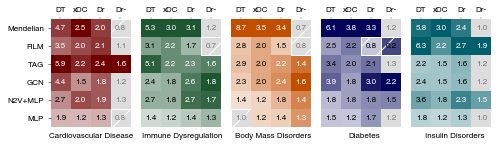

In [3]:
def colorFader(c1="#000000", c2="#ffffff", mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def plot_results(ors, pvals = None, need_transpose = True, pval_cutoff=0.05, adjust = False, extra_height = 2, rotate_xlabels=True):
    """ ors and pvals are dicts which contain one df per disease. dfs have n_methods rows and n_disease_subtypes columns """
    import numpy as np
    from statsmodels.stats.multitest import fdrcorrection as fdr
    border_size = 0.01
    regular_height = 1
    break_height = 0.5
    break_width = 0.5
    regular_width = 1 - border_size
    value_font_size = medium_font
    label_font_size = medium_font
    
    crimson = "#6f0000"
    navy = "#02055a"
    jungle = "#1e5631"
    tan = "#c24e00"
    petrol = "#005f6a"
    purple = "#3c1361"
    grey = "#bbbbbb"

    color_gradients = []
    for colors in [crimson, jungle, tan, navy, petrol]:
        color_gradients.append({x: colorFader(c1 = colors, mix = ((100-x)/100) * 0.85 ) for x in range(101)})

    grey_gradient = {x: colorFader(c1 = grey, mix = ((100-x)/100) * 0.85 ) for x in range(101)}

    outer_labels = list(ors.keys())
    diseases = []
    one_large_df = None
    dfs = []
    main_diseases = []

    for i, (disease, df) in enumerate(ors.items()):
        if need_transpose:
            df = df.transpose()
        for subtype in df.columns:
            main_diseases.append((i, disease))
        diseases.extend(list(df.columns) + ["break"])
        methods = df.index.tolist()[::-1]
        dfs.append(df)

    pval_dfs = []
    for i, (disease, df) in enumerate(pvals.items()):
        if need_transpose:
            df = df.transpose()
        pval_dfs.append(df)

    one_large_df = pd.concat(dfs, axis=1)
    pval_df = pd.concat(pval_dfs, axis=1)

    # remove last break
    diseases = diseases[:-1]
    
    fig, ax = plt.subplots(figsize=(full_width*cm, (full_width*cm / 3.3)))
    
    diseases_without_breaks = [label for label in diseases if label != "break"]

    values = one_large_df.values
    pvals = pval_df.values
    if adjust:
        pvals_shape = pvals.shape
        pvals = fdr(pvals.flatten())[1].reshape(pvals_shape)
    
    all_main_diseases = main_diseases[:]
    for i, index in enumerate(methods):
        main_diseases = all_main_diseases[:]
        running_index = 0
        for c, column in enumerate(diseases):
                
            
            height = break_height if index == "break" else regular_height
            width = break_width if column == "break" else regular_width

            kwargs = {}
            if "break" in [index, column]:
                color = "w"
            else:
                main_disease = main_diseases[0]
                main_diseases.remove(main_disease)

                value_disease_index = running_index
                minmax_means = (values[:, value_disease_index] - 1) / (np.max(values[:, value_disease_index]) - 1)
                if pvals[methods[::-1].index(index), value_disease_index] > pval_cutoff:
                    color = "#dddddd"
                    significant = False
                else:
                    colors = color_gradients[main_disease[0]]
                    color = colors[abs(int(100 * minmax_means[methods[::-1].index(index)]))]
                    significant = True

                
                if values[methods[::-1].index(index), value_disease_index] < 1:
                    kwargs.update({"edgecolor": 'white', "hatch": "/"})
                

            bottom = np.sum([break_height if _method == "break" else regular_height for _method in methods[:i]])

            x_position = np.sum([break_width if _disease == "break" else regular_width for _disease in diseases[:c]])

            ax.bar(x_position, height=height - border_size, bottom=bottom,
                                color=color, width=width, **kwargs)
                
            
            if not "break" in [index, column]:
                if significant:
                    color = "w" if minmax_means[methods[::-1].index(index)] > 0.5 else "black"
                else: 
                    color = "#777777"
                text = str(round(values[methods[::-1].index(index), value_disease_index], 1))
                            
                ax.text(x_position, bottom + (0.5*height), text, ha='center',va='center',
                                    size=value_font_size, color=color)
                
            if column != "break":
                running_index += 1

    yticks = []
    for index in range(len(methods)):
        yticks.append(np.sum([break_height if label == "break" else regular_height for label in methods[:index + 1]]) - 0.5)

    xticks = []
    for index in range(len(diseases)):
        xticks.append(np.sum([break_width if label == "break" else regular_width for label in diseases[:index + 1]]) - 1)

    ax.set_yticks(np.asarray(yticks)[np.asarray([label != "break" for label in methods], dtype = np.bool8)])
    methods = ["Mendelian" if label == "Mendelians" else label for label in methods]
    ax.set_yticklabels([label for label in methods if label != "break"], size=label_font_size)
    ax2 = ax.twiny()
    diseases = ["xDC" if disease == "#DC" else disease for disease in diseases]
    ax.set_xticks(np.asarray(xticks)[np.asarray([label != "break" for label in diseases], dtype = np.bool8)])
    ax.set_xticklabels([label for label in diseases if label != "break"], ha="center", rotation=90 if rotate_xlabels else 0, size=label_font_size)


    ax2.set_xticks([1.5, 6, 10.5, 15, 19.5])
    ax2.set_xticklabels(outer_labels, size=label_font_size)

    ax.xaxis.set_ticks_position('top')
    ax2.xaxis.set_ticks_position('bottom')

    for axe in [ax, ax2]:
        axe.spines['top'].set_visible(False)
        axe.spines['right'].set_visible(False)
        axe.spines['bottom'].set_visible(False)
        axe.spines['left'].set_visible(False)
    ax.set_ylim((0, np.sum([break_height if _method == "break" else regular_height for _method in methods]) - border_size))
    ax.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    ax2.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    
    plt.tick_params(bottom = False)
    plt.tight_layout()
    return fig, ax

fig, ax = plot_results(results_dict_values, results_dict_pvals, need_transpose=False, extra_height=0, rotate_xlabels=False)

plt.savefig("drug_all.svg", bbox_inches="tight", transparent=False)

# Now get results with FiLM-Unbiased

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
#os.chdir("~/ppi-core-genes/")
phenotypes = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "film_unbiased", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "FiLM-Unbiased", "TAG", "GCN", "N2V+MLP", "MLP"]
groups = ["Noncandidate Gene", "Candidate Gene", "Mendelian"]
categories = ["DT", "xDC", "Dr", "Dr-"]
tick_size = 12
label_size = 14

crimson = "#6f0000"
navy = "#02055a"
jungle = "#1e5631"
tan = "#c24e00"
petrol = "#005f6a"
grey = "#bbbbbb"
lightgrey = "#dddddd"
width_ratios= [10, 1]*2
marker_size=10

colors_ = [crimson, jungle, tan, navy, petrol]

results_dict_values = {}
results_dict_pvals = {}
outer_dfs = []
for phenotype in phenotypes:
    plot_df_values = pd.DataFrame(columns=categories, index=["Mendelians"] + pretty_methods)
    plot_df_pvals = pd.DataFrame(columns=categories, index=["Mendelians"] + pretty_methods)
    need_to_set_mendelians = True
    dfs = []
    for method, pretty_method in zip(methods, pretty_methods):
        if method in ["gcn", "mlp", "n2vmlp"] and phenotype == "Immune Dysregulation":
            method += "_new"
    
        config_paths = {"Insulin Disorders": "configs/config_insulin_disorder_{}.yaml".format(method),
                        "Diabetes": "configs/config_diabetes_{}.yaml".format(method),
                        "Body Mass Disorders": "configs/config_bm_disorder_{}.yaml".format(method),
                        "Cardiovascular Disease": "configs/config_cardiovascular_{}.yaml".format(method),
                        "Immune Dysregulation": "configs/config_immune_dysregulation_{}.yaml".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            config_paths[phenotype] = "configs/config_immune_dysregulation_{}_forreal.yaml".format(method)

        config = Config()
        config.parse_yaml(config_paths[phenotype])

        pp = PostProcessor(config)

        import json

        outer_results_paths = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}outer_results.json".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}outer_results.json".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}outer_results.json".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}outer_results.json".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}outer_results.json".format(method)}

                        

        if method == "film" and phenotype == "Immune Dysregulation":
            outer_results_paths[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forrealouter_results.json".format(method)

        results_files = {"Insulin Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/insulin_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Diabetes": "/lustre/groups/epigenereg01/projects/ppi-florin/results/diabetes_{}_outer_0_fold_1.tsv".format(method),
                        "Body Mass Disorders": "/lustre/groups/epigenereg01/projects/ppi-florin/results/bm_disorder_{}_outer_0_fold_1.tsv".format(method),
                        "Cardiovascular Disease": "/lustre/groups/epigenereg01/projects/ppi-florin/results/cardiovascular_{}_outer_0_fold_1.tsv".format(method),
                        "Immune Dysregulation": "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_outer_0_fold_1.tsv".format(method)}

        if method == "film" and phenotype == "Immune Dysregulation":
            results_files[phenotype] = "/lustre/groups/epigenereg01/projects/ppi-florin/results/immune_dysregulation_{}_forreal_outer_0_fold_1.tsv".format(method)

        with open(outer_results_paths[phenotype], "r") as file:
            results = json.load(file)
        pp.outer_result = results
        pp.init_pp_table()
        drug_target_results, pvals, (not_predicted_degrees, predicted_degrees, positive_degrees), df = pp.drugtarget(results_files[phenotype], plot=False)

        total_druggable, leftover_druggable, df2 = pp.druggable(results_files[phenotype])
        df2.columns = [cname + " " if cname in ["Group Name", "Group N"] else cname for cname in df2.columns]
        df["  "] = [" "] * 3
        df = pd.concat([df, df2], axis=1, join="inner")
        dfs.append(df)

        if need_to_set_mendelians:
            plot_df_values.loc["Mendelians", "DT"] = drug_target_results[0][0]
            plot_df_pvals.loc["Mendelians", "DT"] = drug_target_results[0][1]
            plot_df_values.loc["Mendelians", "Dr"] = total_druggable[0][0]
            plot_df_pvals.loc["Mendelians", "Dr"] = total_druggable[0][1]
            plot_df_values.loc["Mendelians", "Dr-"] = leftover_druggable[0][0]
            plot_df_pvals.loc["Mendelians", "Dr-"] = leftover_druggable[0][1]
            plot_df_values.loc["Mendelians", "xDC"] = np.median(positive_degrees) / np.median(not_predicted_degrees)
            plot_df_pvals.loc["Mendelians", "xDC"] = pvals[1]
            need_to_set_mendelians = False

        plot_df_values.loc[pretty_method, "DT"] = drug_target_results[1][0]
        plot_df_pvals.loc[pretty_method, "DT"] = drug_target_results[1][1]
        plot_df_values.loc[pretty_method, "Dr"] = total_druggable[1][0]
        plot_df_pvals.loc[pretty_method, "Dr"] = total_druggable[1][1]
        plot_df_values.loc[pretty_method, "Dr-"] = leftover_druggable[1][0]
        plot_df_pvals.loc[pretty_method, "Dr-"] = leftover_druggable[1][1]
        plot_df_values.loc[pretty_method, "xDC"] = np.median(predicted_degrees) / np.median(not_predicted_degrees)
        plot_df_pvals.loc[pretty_method, "xDC"] = pvals[0]
    

    dfs = pd.concat(dfs, keys = pretty_methods)
    dfs.reset_index(inplace=True)
    dfs.drop("level_1", inplace=True, axis="columns")
    dfs.columns = ["Method"] + dfs.columns[1:].tolist()
    for column in dfs.columns:
        if "OR" in column:
            dfs[column] = dfs[column].round(3)
        if "N " in column:
            dfs[column] = dfs[column].astype(int)
    outer_dfs.append(dfs)
    results_dict_values.update({phenotype: plot_df_values})
    results_dict_pvals.update({phenotype: plot_df_pvals})

dt_pvals = []
xdc_pvals = []
dr_pvals = []
drminus_pvals = []

for df in outer_dfs:
    dt_pvals.extend(df["pval DT unadjusted"][~np.isnan(df["pval DT unadjusted"])].tolist())
    xdc_pvals.extend(df["pval xDC unadjusted"].tolist())
    dr_pvals.extend(df["pval Dr unadjusted"][~np.isnan(df["pval Dr unadjusted"])].tolist())
    drminus_pvals.extend(df["pval Dr- unadjusted"][~np.isnan(df["pval Dr- unadjusted"])].tolist())

dt_pvals_adjusted = fdr(dt_pvals)[1]
xdc_pvals_adjusted = fdr(xdc_pvals)[1]
dr_pvals_adjusted = fdr(dr_pvals)[1]
drminus_pvals_adjusted = fdr(drminus_pvals)[1]

n_dfs = len(outer_dfs)

for df, df_dt_pvals_adj, df_xdc_pvals_adj, df_dr_pvals_adj, drminus_pvals_adj, phenotype in \
    zip(outer_dfs,  np.array_split(dt_pvals_adjusted, n_dfs), np.array_split(xdc_pvals_adjusted, n_dfs), \
    np.array_split(dr_pvals_adjusted, n_dfs), np.array_split(drminus_pvals_adjusted, n_dfs), phenotypes):

    df.loc[~np.isnan(df["pval DT unadjusted"]), "pval DT adjusted (FDR)"] = df_dt_pvals_adj
    df["pval xDC adjusted (FDR)"] = df_xdc_pvals_adj
    df.loc[~np.isnan(df["pval Dr unadjusted"]), "pval Dr adjusted (FDR)"] = df_dr_pvals_adj
    df.loc[~np.isnan(df["pval Dr- unadjusted"]), "pval Dr- adjusted (FDR)"] = drminus_pvals_adj
    df.to_csv("statistical_dump/{}_drugtarget_unbiased.tsv".format(phenotype), sep="\t", index=False)
    plot_df_pvals = results_dict_pvals[phenotype].copy()
    need_to_set_mendelians = True
    for method in pretty_methods:
        if need_to_set_mendelians:
            plot_df_pvals.loc["Mendelians", "DT"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval DT adjusted (FDR)"]].values[0]
            plot_df_pvals.loc["Mendelians", "xDC"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval xDC adjusted (FDR)"]].values[0]
            plot_df_pvals.loc["Mendelians", "Dr"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval Dr adjusted (FDR)"]].values[0]
            plot_df_pvals.loc["Mendelians", "Dr-"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Mendelian"), ["pval Dr- adjusted (FDR)"]].values[0]
            need_to_set_mendelians = False

        plot_df_pvals.loc[method, "DT"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval DT adjusted (FDR)"]].values[0]
        plot_df_pvals.loc[method, "xDC"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval xDC adjusted (FDR)"]].values[0]
        plot_df_pvals.loc[method, "Dr"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval Dr adjusted (FDR)"]].values[0]
        plot_df_pvals.loc[method, "Dr-"] = df.loc[(df["Method"] == method) & (df["Group Name"] == "Candidate Gene"), ["pval Dr- adjusted (FDR)"]].values[0]
    
    results_dict_pvals.update({phenotype: plot_df_pvals})

print(results_dict_values['Cardiovascular Disease'])

cardiovascular_film 2023-01-27 12:05:57,856 [INFO] speos.postprocessing.postprocessor: Reading compound drug interaction graph from ~/ppi-core-genes/data/drkg/cgi.tsv
cardiovascular_film 2023-01-27 12:05:58,980 [INFO] speos.postprocessing.postprocessor: Reading translation table from ./data/hgnc_official_list.tsv
cardiovascular_film 2023-01-27 12:05:59,477 [INFO] speos.postprocessing.postprocessor: Total of 8888 drug targets, 8401 of them match with our translation table.
cardiovascular_film 2023-01-27 12:05:59,477 [INFO] speos.postprocessing.postprocessor: Found 510 drug targets genes among the 610 known positive genes (p: 4.69e-76, OR: 5.752), leaving 7891 in 16791 Unknowns
cardiovascular_film 2023-01-27 12:05:59,595 [INFO] speos.postprocessing.postprocessor: Fishers Exact Test for Drug Targets among Predicted Genes. p: 6.81e-63, OR: 1.848
cardiovascular_film 2023-01-27 12:05:59,596 [INFO] speos.postprocessing.postprocessor: Drug Targets Confusion Matrix:
[[2309 5582]
 [1628 7272]]
c

                     DT   xDC        Dr       Dr-
Mendelians     4.650824   2.5  2.028791  0.821587
FiLM           3.549776   2.0  2.094156  1.096855
FiLM-Unbiased  3.925289   2.0  2.296275   1.26927
TAG            5.933568  2.25  2.415599  1.616936
GCN            4.352344   1.5  1.841789  1.229857
N2V+MLP          2.7486   2.0  1.856836  1.306803
MLP            1.855089  1.25   1.27508  0.846812


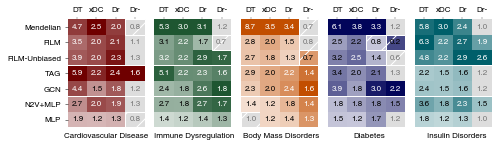

In [5]:
fig, ax = plot_results(results_dict_values, results_dict_pvals, need_transpose=False, extra_height=0.1, rotate_xlabels=False)

plt.savefig("drug_all_unbiased.svg", bbox_inches="tight", transparent=False)